In [1]:
import os
import numpy as np
import skimage.io as skio
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from skimage.transform import resize
from torch.utils.data import TensorDataset, DataLoader


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Part 3: Train with Larger Dataset

In [3]:
import xml.etree.ElementTree as ET

tree = ET.parse("ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml")
root = tree.getroot()
root_dir = "ibug_300W_large_face_landmark_dataset"

bboxes = []  # face bounding box used to crop the image
landmarks = []  # the facial keypoints/landmarks for the whole training dataset
img_filenames = []  # the image names for the whole dataset

for filename in root[2]:
    img_filenames.append(os.path.join(root_dir, filename.attrib["file"]))
    box = filename[0].attrib
    # x, y for the top left corner of the box, w, h for box width and height
    bboxes.append([box["left"], box["top"], box["width"], box["height"]])

    landmark = []
    for num in range(68):
        x_coordinate = int(filename[0][num].attrib["x"])
        y_coordinate = int(filename[0][num].attrib["y"])
        landmark.append([x_coordinate, y_coordinate])
    landmarks.append(landmark)

landmarks = np.array(landmarks).astype("float32")
bboxes = np.array(bboxes).astype("float32")


In [4]:
from tqdm import tqdm


def load_data(start_idx, end_idx, bboxes, img_filenames, landmarks, data_type="training"):
    if not os.path.isfile("npy/" + data_type + "_faces.npy") or not os.path.isfile("npy/" + data_type + "_points.npy"):
        faces, points = [], []

        for i in tqdm(range(start_idx, end_idx), desc=f"{data_type} data", unit="img"):
            img = skio.imread(img_filenames[i], as_gray=True)
            bbox = bboxes[i]
            landmark = landmarks[i]

            x = np.array([item[0] - max(0, bbox[0]) for item in landmark])
            y = np.array([item[1] - max(0, bbox[1]) for item in landmark])
            xy = np.dstack([x.T, y.T])[0]

            img = img[max(0, int(bbox[1])) : int(bbox[1] + bbox[3]), max(0, int(bbox[0])) : int(bbox[0] + bbox[2])]

            # scaling
            y_factor = 224 / img.shape[0]
            x_factor = 224 / img.shape[1]
            scale_matrix = np.array([[x_factor, 0], [0, y_factor]])
            xy = ((scale_matrix @ xy.T).T / 224.0).astype(np.float32)
            img = resize(img, (224, 224), anti_aliasing=True).astype(np.float32) - 0.5

            faces.append(img)
            points.append(xy)

        faces = np.array(faces)
        points = np.array(points)
        np.save("npy/" + data_type + "_faces.npy", faces)
        np.save("npy/" + data_type + "_points.npy", points)
    else:
        faces = np.load("npy/" + data_type + "_faces.npy")
        points = np.load("npy/" + data_type + "_points.npy")

    faces = torch.from_numpy(faces)
    points = torch.from_numpy(points)
    return faces, points


In [5]:
x_train, y_train = load_data(0, 6000, bboxes, img_filenames, landmarks)
x_val, y_val = load_data(6000, 6666, bboxes, img_filenames, landmarks, "validation")


In [6]:
def adjust_learning_rate(optimizer, epoch):
    lr = 0.001 * (0.6 ** ((epoch + 1) // 10))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def fit_model(model, loss_func, optimizer, input_shape, epochs, train, test):
    train_losses, val_losses = [], []
    batch = len(train)

    for epoch in range(epochs):
        model.train()
        train_loss, val_loss = [], []
        adjust_learning_rate(optimizer, epoch)
        with tqdm(total=batch, unit="batch") as tqdm_bar:
            tqdm_bar.set_description(f"Epoch {epoch+1:2}/{epochs:2}")
            for inputs, labels in train:
                inputs = inputs.view(input_shape)
                labels = labels.view((inputs.shape[0], -1))

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the gradients
                optimizer.zero_grad()

                # forward + backpropagation + optimize
                pred = model(inputs)
                loss = loss_func(pred, labels)
                loss.backward()
                optimizer.step()

                train_loss.append(loss.item())

                tqdm_bar.update(1)
                tqdm_bar.set_postfix(loss=f"{np.mean(train_loss):.6f}", val_loss=f"{0:.6f}")

            model.eval()
            for inputs, labels in test:
                inputs = inputs.view(input_shape)
                labels = labels.view((inputs.shape[0], -1))

                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.no_grad():
                    pred = model(inputs)
                    loss = loss_func(pred, labels)
                    val_loss.append(loss.item())

            tqdm_bar.set_postfix(loss=f"{np.mean(train_loss):.6f}", val_loss=f"{np.mean(val_loss):.6f}")
            tqdm_bar.close()

        train_losses.append(np.mean(train_loss))
        val_losses.append(np.mean(val_loss))

    return train_losses, val_losses


In [7]:
def plot_loss(train_loss, val_loss, epochs):
    plt.plot(range(epochs), train_loss)
    plt.plot(range(epochs), val_loss)
    plt.legend(["train", "val"])
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()


In [8]:
def plot_best_and_worst_5(dataset, model, loss_func, size, dot_size=25):
    ranking = []
    for inputs, labels in dataset:
        inputs = inputs.unsqueeze(0).unsqueeze(0)
        labels = labels.unsqueeze(0).view(1, -1)

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            pred = model(inputs)
            loss = loss_func(pred, labels)

        pred = pred.cpu().detach().numpy()[0].reshape(-1, 2)
        labels = labels.cpu().numpy()[0].reshape(-1, 2)
        ranking.append([inputs[0][0].cpu().numpy(), pred, labels, loss])

    ranking.sort(key=lambda x: x[3])

    # best five
    print("Best five")
    plt.figure(figsize=(16, 12))
    for i in range(5):
        arr = ranking[i]
        plt.subplot(1, 5, i + 1)
        plt.imshow(arr[0], cmap="gray")
        plt.scatter(arr[2][:, 0] * size[1], arr[2][:, 1] * size[0], s=dot_size, c="green", label="ground truth")
        plt.scatter(arr[1][:, 0] * size[1], arr[1][:, 1] * size[0], s=dot_size, c="red", label="prediction")
        plt.legend(fontsize=8)
        plt.title(f"loss: {arr[3]:.6f}")
    plt.show()

    print()

    # worst five
    print("Worst five")
    plt.figure(figsize=(16, 12))
    for i in range(1, 6):
        arr = ranking[-i]
        plt.subplot(1, 5, i)
        plt.imshow(arr[0], cmap="gray")
        plt.scatter(arr[2][:, 0] * size[1], arr[2][:, 1] * size[0], s=dot_size, c="green", label="ground truth")
        plt.scatter(arr[1][:, 0] * size[1], arr[1][:, 1] * size[0], s=dot_size, c="red", label="prediction")
        plt.legend(fontsize=8)
        plt.title(f"loss: {arr[3]:.6f}")
    plt.show()


In [9]:
# hyperparameters
epochs = 25
batch_size = 100
learning_rate = 0.001


In [10]:
train = TensorDataset(x_train, y_train)
validation = TensorDataset(x_val, y_val)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation, batch_size=batch_size, shuffle=False)


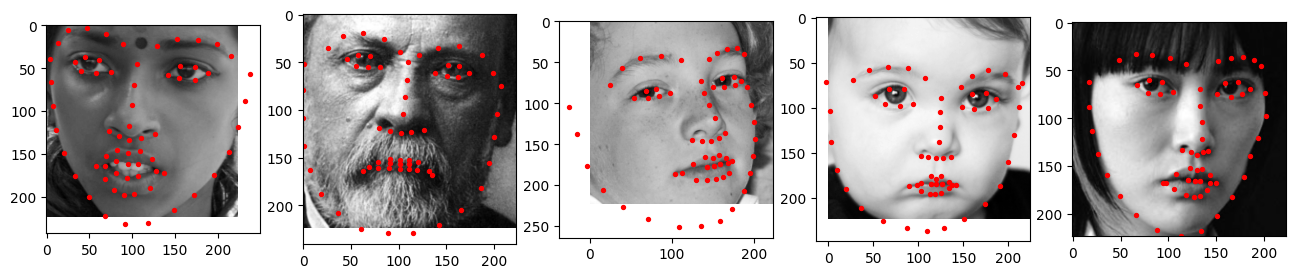

In [11]:
plt.figure(figsize=(16, 12))
for x, y in train_loader:
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(x[i].numpy(), cmap="gray")
        plt.scatter(y[i, :, 0].numpy() * 224, y[i, :, 1].numpy() * 224, s=8, c="red")
    break
plt.show()


In [12]:
from torchvision import models

resnet18 = models.resnet18(weights="IMAGENET1K_V1")

# adjust layers
resnet18.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
resnet18.fc = nn.Linear(512, 136)

resnet18 = resnet18.to(device)
print(resnet18)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
optimizer = optim.Adam(resnet18.parameters(), lr=learning_rate)
loss_func = nn.MSELoss().to(device)
input_shape = (-1, 1, 224, 224)


In [14]:
train_losses, val_losses = fit_model(resnet18, loss_func, optimizer, input_shape, epochs, train_loader, validation_loader)


Epoch 25/25: 100%|██████████| 60/60 [00:27<00:00,  2.21batch/s, loss=0.000357, val_loss=0.000711]


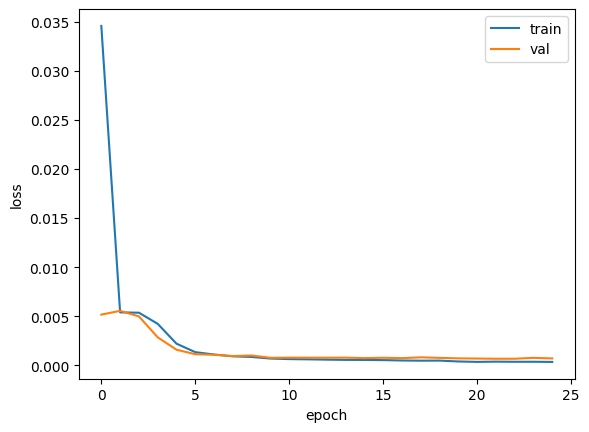

In [15]:
plot_loss(train_losses, val_losses, epochs)


Best five


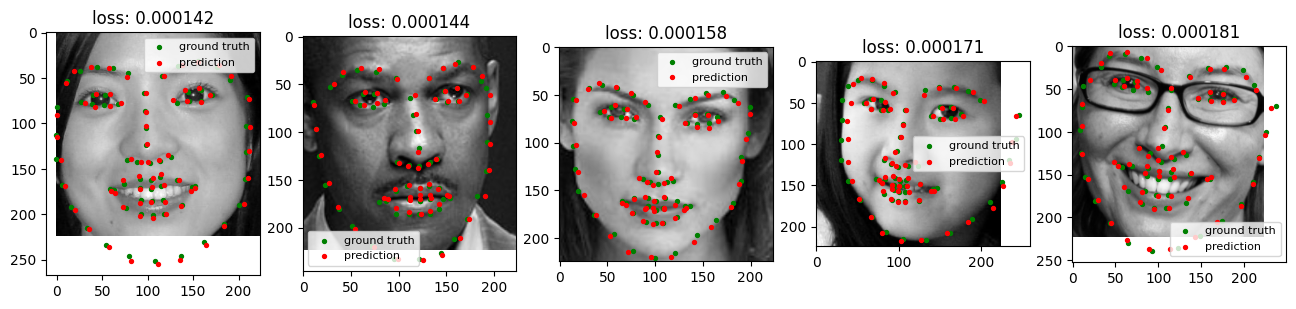


Worst five


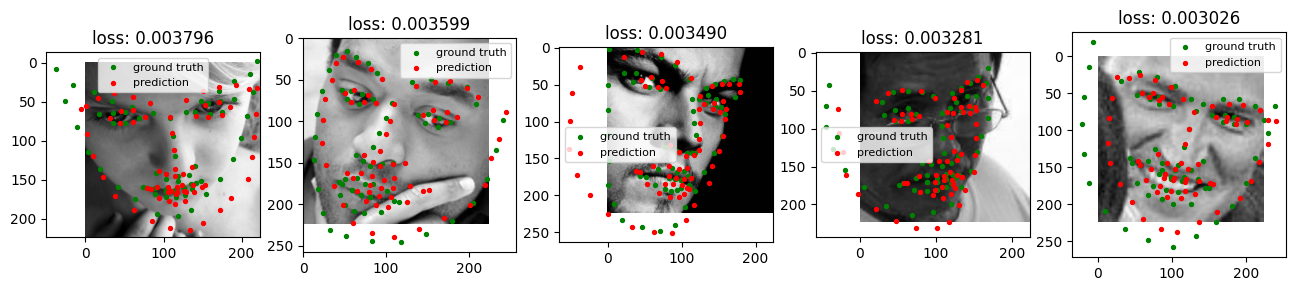

In [16]:
resnet18.eval()
plot_best_and_worst_5(validation, resnet18, loss_func, (224, 224), 8)


In [50]:
import csv


def save_test_result(model, shape=(-1, 1, 224, 224)):
    tree = ET.parse("ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test_parsed.xml")
    root = tree.getroot()
    root_dir = "ibug_300W_large_face_landmark_dataset"

    bboxes = []  # face bounding box used to crop the image
    img_filenames = []  # the image names for the whole dataset

    for filename in root[2]:
        img_filenames.append(os.path.join(root_dir, filename.attrib["file"]))
        box = filename[0].attrib
        # x, y for the top left corner of the box, w, h for box width and height
        bboxes.append([box["left"], box["top"], box["width"], box["height"]])

    bboxes = np.array(bboxes).astype("float32")

    model.eval()
    table = [["Id", "Predicted"]]
    for i in tqdm(range(len(img_filenames)), desc="test data", unit="img"):
        img = skio.imread(img_filenames[i], as_gray=True)
        bbox = bboxes[i]

        img = img[max(0, int(bbox[1])) : int(bbox[1] + bbox[3]), max(0, int(bbox[0])) : int(bbox[0] + bbox[2])]

        # scaling
        img = resize(img, (224, 224), anti_aliasing=True).astype(np.float32) - 0.5

        tensor_img = torch.from_numpy(img).view(shape)
        tensor_img = tensor_img.to(device)

        with torch.no_grad():
            pred = model(tensor_img)

        pred = pred.cpu().detach().numpy().reshape(-1, 2)

        for it in range(pred.shape[0]):
            x, y = pred[it, 0], pred[it, 1]
            x_name = f"img_{str(i+1).zfill(4)}_keypoints_{str(it+1).zfill(2)}_x"
            y_name = f"img_{str(i+1).zfill(4)}_keypoints_{str(it+1).zfill(2)}_y"
            table.append([x_name, x * 224])
            table.append([y_name, y * 224])

    with open("output.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(table)


In [51]:
save_test_result(resnet18)

test data:   0%|          | 0/1008 [00:00<?, ?img/s]

test data: 100%|██████████| 1008/1008 [00:45<00:00, 22.20img/s]
